# Customer Analytics in FMGC Industry (Part 2)
#### by Sooyeon Won

### Keywords 

- Marketing Mix 
- STP framework
- Purchase Analytics 
- Predictive Analysis
- Price Elasticity
- Modeling Brand Choice


### Contents 

<ul>
<li><a href="#Introduction">1. Introduction</a></li> 
<li><a href="#Preparation">2. Data Preparation</a></li>
<li><a href="#Exploration">3. Data Exploration</a></li>
<li><a href="#Analysis">4. Data Analysis</a></li>
&emsp;4.1. Customer Analytics<br>
&emsp;4.2. Purchase Analytics <br>
&emsp;&emsp;&emsp;i. Descriptive Analyses by Segment <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-1. The Proportion of each Segment <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-2. Purchase Occasions and Purchase Incidences <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-3. Brand Chocie <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-4. Revenue Comparison between segments <br>
&emsp;&emsp;&emsp;ii. Predictive Analyses <br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-1. Modeling Purchase Incidence<br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-2. Modeling Brand Choice <br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-3. Modeling Purchase Quantity <br>
<li><a href="#Conclusion">5. Conclusion</a></li>
</ul>


## 4. Data Analysis
### 4.2. Purchase Analytics
- Data Preparation from Part 1
- ii. Predictive Analyses <br>
&emsp;&emsp;&emsp; ii-1. Modeling Purchase Incidence<br>
&emsp;&emsp;&emsp; **ii-2. Modeling Brand Choice** <br>
&emsp;&emsp;&emsp; ii-3. Modeling Purchase Quantity <br>

### Data Preparation from Part 1

In [1]:
# Import the relevant libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import matplotlib.axes as axs
%matplotlib inline
plt.rc("font", size=14)
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

# Import pickle in order to be able to load our pickled objects.
import pickle

# Import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 

In [2]:
# Load data
purchase_df = pd.read_csv('purchase data.csv', index_col = 0)
price_elasticities = pd.read_csv('price_elasticities.csv', index_col = 0)

# Import Scaler, PCA, K-Means
scaler = pickle.load(open('scaler.pickle', 'rb'))
pca = pickle.load(open('pca.pickle', 'rb'))
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardisation
features = purchase_df[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
purchase_segm_std = scaler.transform(features)
# Apply PCA
purchase_segm_pca = pca.transform(purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(purchase_segm_pca)

# Create a copy of the data frame
purchase_predictors = purchase_df.copy()

# Add segment labels
purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
purchase_predictors = purchase_predictors.reset_index()
purchase_predictors = purchase_predictors.merge(segment_dummies, how='inner',
                                                left_on = purchase_predictors.index,
                                                right_on = segment_dummies.index)

In [3]:
df_pa = purchase_predictors.set_index('ID').iloc[:,1:].copy()
df_pa.head() # Data is ready to conduct predictive analysis 

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,
200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0


### ii. Predictive Analysis 
In this section, I mainly conduct predictive analytics. Using machine learning models I estimated price elasticities. The situation, in this part of analysis, is that customers are in the store and have decided to purchase a product we are interested in: which brand they'll choose. Furthermore, I analysed how the choice of customer would be changed as competitors’ price is changing.

### ii-2. Modeling Brand Choice <br>
<li><a href="#BrandChoice">ii-2-1. Brand Choice</a></li>
<li><a href="#OPEB5">ii-2-2. Own Price Elasticity Brand 5</a></li>
<li><a href="#CPEB54">ii-2-3. Cross Price Elasticity Brand 5, Cross Brand 4</a></li> 
<li><a href="#OaCPEbySeg">ii-2-4. Own and Cross-Price Elasticity by Segment</a></li> 

> The chocolate brand has values from 0 to 5 indicating which of the 5 brands are chosen. The entry is indicated as 0, if no purchase was made during the particular shopping trip. To investigate the brand choice, I focused on these entries where brand is from 1 to 5. By doing s, we can be sure that a purchase was made and a certain brand was preferred. <br><br>
The final goal of the brand choice model is to determine what the probability to choose a certain brand is. This would help marketers analyse their customers‘ behaviour. Based on the analysis, the marketers can increase sales and certainly the goal would help to increase customer satisfaction. I take advantage of a "Logistic Regression Algorithm". This time I apply it to a multi class scenario, because now there are 5 classes (brands). This approach is known as a **"Multi-Nominal-Logistic-Regression / Classifier"**.


<a id='BrandChoice'></a>
### ii-2-1. Brand Choice

In [4]:
brand_choice = df_pa.query('Incidence ==1')
brand_choice.head()

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,
200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,...,47,1,110866,1,0,0,1,0,0,0
200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,...,47,1,110866,1,0,0,1,0,0,0
200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,...,47,1,110866,1,0,0,1,0,0,0
200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,...,47,1,110866,1,0,0,1,0,0,0


In [5]:
# The target variable of the model is "brand".
output = brand_choice['Brand']
# Predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
inputs = brand_choice[features]
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(inputs, output)

LogisticRegression(multi_class='multinomial', solver='sag')

> Like the previous analysis, I predict the brand  based on price, but now we're interested in the prices of each individual
brand and the interactions between them.

In [6]:
# Turn off scientific notation in pandas 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Make some transformations on the coefficients data frame to increase readability.
# Tanspose the data frame, to keep with the conventional representation of results.
# Add labels for the columns and the index, which represent the coefficients of the brands and prices, respectively. 
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_), columns = coefficients, index = prices)

bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


> The Dataframe "bc_coef" presents the beta values. 
>- "Coef_Brand_1": The Brand 1 the coefficient for the own brand with respect to price is negative (-3,92), while it's positive for all other prices except Brand 5. We know that the higher the price of the own product, the lower the probability for it to be purchased.
So it makes sense for the own brand price coefficient to be negative.
>- On the other hand, the more the price of a competitor increases, the higher the probability of customers switching to our own brand would be. Hence there is a positive relationship between our own brands (Brand 5) purchase probability and a competitive brand increasing their price. 
>- It can be easily realized that the choice probability for own brand and the choice probabilities for all the other brands are interrelated and a marketing mix tool of own brand reflects not only the choice probability for that brand but the choice probabilities for all other brands as well. These effects are known as own **"Brand Effects"** and **"Cross Brand Effects"**. Throughout this analysis, I examined both in more detail.


<a id='OPEB5'></a>
### ii-2-2. Own Price Elasticity Brand 5

In this section I chose the Brand 5 and regarded as the own product which should be analysed. Then I expand the findings into developing a strategy to target customers. 

Firstly, I examine the effects of price changes to own brand price. Then I explore the effects of competitors' product price changing on the brand 5 product. This information contains in the Brand 5 own price elasticity and the cross price elasticities respectively. 

For this analysis, I chose Brand 5 chocolate product, the most expensive brand. Like before, in order to predict the brand elasticities, I generated a dataframe which contains the same features to fit the brand choice model. Basically I predict the purchase probability of brand 5 for different price points to calculate the predicted probabilities, Then apply the predict proper method on the brand choice model.

In [7]:
price_range = np.arange(0.5, 3.5, 0.01)

In [8]:
# Calculate price elasticity of brand choice.
# Create a data frame with price columns, which the model will use to predict the brand choice probabilities.
own_brand_5 = pd.DataFrame( {'Price_1':  brand_choice['Price_1'].mean(),
                             'Price_2':  brand_choice['Price_2'].mean(), 
                             'Price_3':  brand_choice['Price_3'].mean(),
                             'Price_4':  brand_choice['Price_4'].mean(),
                             'Price_5':  price_range} , index = np.arange(price_range.size))
own_brand_5.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.38,1.76,2.01,2.16,0.50
1,1.38,1.76,2.01,2.16,0.51
2,1.38,1.76,2.01,2.16,0.52
3,1.38,1.76,2.01,2.16,0.53
4,1.38,1.76,2.01,2.16,0.54


In [9]:
# Brand Choice Model prediction.
pred_brand_5 = model_brand_choice.predict_proba(own_brand_5)

# The model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the fifth brand we need to obtain the last column located on position 4,
# as we're starting to count from 0.
pred_own_brand_5 = pred_brand_5[: ][:, 4]

# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
np.round(beta5, 4)

-1.0879

In [10]:
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pred_own_brand_5)
price_elasticities.loc['Brand5_own_Avg'] = own_price_elasticity_brand_5
price_elasticities

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Price_Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,...,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean_PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,...,-7.89,-7.91,-7.94,-7.96,-7.99,-8.01,-8.04,-8.06,-8.09,-8.11
PE_Segment_0_FO,-0.03,-0.03,-0.04,-0.04,-0.04,-0.04,-0.04,-0.05,-0.05,-0.05,...,-12.23,-12.27,-12.31,-12.34,-12.38,-12.42,-12.45,-12.49,-12.53,-12.56
PE_Segment_1_Cf,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.15,-0.16,...,-5.62,-5.64,-5.66,-5.68,-5.70,-5.72,-5.74,-5.76,-5.78,-5.80
PE_Segment_2_Strd,-0.21,-0.22,-0.22,-0.23,-0.24,-0.25,-0.25,-0.26,-0.27,-0.27,...,-4.97,-4.98,-5.00,-5.02,-5.03,-5.05,-5.07,-5.09,-5.10,-5.12
PE_Segment_3_WO,-0.17,-0.17,-0.18,-0.18,-0.19,-0.19,-0.20,-0.20,-0.21,-0.21,...,-4.08,-4.10,-4.12,-4.13,-4.15,-4.16,-4.18,-4.19,-4.21,-4.22
Elasticity_Promotion_1,-0.13,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.16,-0.17,...,-4.77,-4.79,-4.81,-4.83,-4.84,-4.86,-4.88,-4.90,-4.92,-4.93
Elasticity_Promotion_0,-0.20,-0.20,-0.21,-0.21,-0.22,-0.23,-0.23,-0.24,-0.25,-0.25,...,-4.90,-4.92,-4.93,-4.95,-4.97,-4.98,-5.00,-5.02,-5.03,-5.05
Brand5_own_Avg,-0.05,-0.05,-0.05,-0.05,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,...,-3.14,-3.16,-3.18,-3.19,-3.21,-3.23,-3.24,-3.26,-3.27,-3.29


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

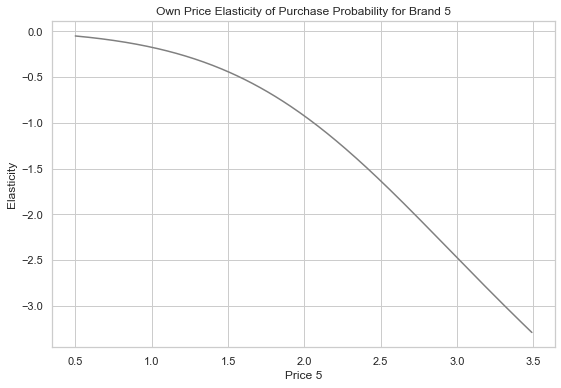

In [11]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')

<a id='CPEB54'></a>
### ii-2-3. Cross Price Elasticity Brand 5, Cross Brand 4

Now, what would happen to the purchase probability of brand 5, if a competitor changed their pricing? Among other brands, I compared the Brand 5 with Brand 4. The reason is the most expensive chocolate: Brand 5 is highly likely one of the highest qualities (certainly not always, though). Based on this assumption, it seems that the brand 4 seems the closest to the brand 5. Therefore, it would make the most sense to compare these two. I determine the cross price elasticities of "Brand 5" with respect to "Brand 4".

In [12]:
brand5_cross_brand4 = pd.DataFrame({'B5CB4_Price_1':  brand_choice['Price_1'].mean(),
                                     'B5CB4_Price_2':  brand_choice['Price_2'].mean(), 
                                     'B5CB4_Price_3':  brand_choice['Price_3'].mean(),
                                     'B5CB4_Price_4':  price_range,
                                     'B5CB4_Price_5':  brand_choice['Price_5'].mean()}, index = np.arange(price_range.size))

brand5_cross_brand4.head()

,B5CB4_Price_1,B5CB4_Price_2,B5CB4_Price_3,B5CB4_Price_4,B5CB4_Price_5
0,1.38,1.76,2.01,0.50,2.65
1,1.38,1.76,2.01,0.51,2.65
2,1.38,1.76,2.01,0.52,2.65
3,1.38,1.76,2.01,0.53,2.65
4,1.38,1.76,2.01,0.54,2.65


In [13]:
# Compute the probabilities by using the previous model brand choice predict probabilities
pred_brand5_cross_brand4 = model_brand_choice.predict_proba(brand5_cross_brand4)

In [14]:
# The probability of choosing the competitor brand 
# Select the purchase probability for brand 4, contained in the 4th column with index 3. 
pred_brand_4 = pred_brand5_cross_brand4[:][:, 3]

In [15]:
# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
np.round(beta5, 4)

-1.0879

[Price Elasticity - Reference](https://365datascience.com/price-elasticity/)
$$ E = -\beta(Own Product Price)*price(Cross Brand)*Pr(Cross Brand) $$ 

Price Elasticity of Probability for Brand Choice is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,further multiplied by the probability for choosing the cross brand.

In [16]:
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pred_brand_4

In [17]:
# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
pd.options.display.max_columns = None
price_elasticities.loc['Brand5_Cross_Brand_4_Avg'] = brand5_cross_brand4_price_elasticity
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price_Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean_PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.96,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.42,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.54,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.59,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.81,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

> From the last row in the table, we examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4. We can see that the values are all are positive. This implies that as the price of the competitor brand increases, so does the probability for purchasing the own brand (Brand 5). Even though the elasticity starts to decrease from the price point 1.48, it is still positive, meaning that the increase in purchase probability for the own brand happens more slowly.

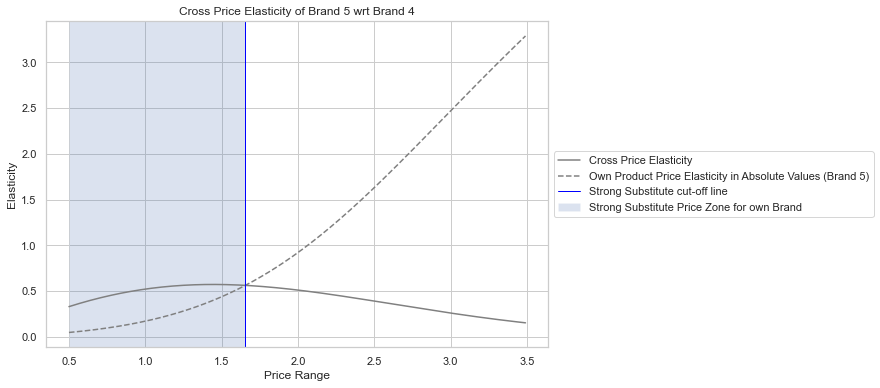

In [18]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey', label ="Cross Price Elasticity")
plt.plot(price_range, np.abs(own_price_elasticity_brand_5), color = 'grey',  
         linestyle = '--',label ="Own Product Price Elasticity in Absolute Values (Brand 5)" )
plt.xlabel('Price Range')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')
plt.axvline(x=1.65, color='blue', linewidth=1, label = "Strong Substitute cut-off line")
plt.axvspan(0.5, 1.65, facecolor='b', alpha=0.2, label = "Strong Substitute Price Zone for own Brand")
# show the legend
plt.legend( bbox_to_anchor = (1, 0.5), loc = 6)
plt.show()

>- The positive values of the elasticities across the price range indicates that if competitor brand 4 increases prices, the purchase probability for Brand 5  would increase. In other words, our competitor raises prices and they start buying our own product more, and the elasticities show us exactly how much more. 
>-If the cross price elasticity is greater than 0, the two products are considered "Substitutes". If, however we were looking at brand 5 cross some type of different products (as an example of products having nothing in common), the cross price elasticity would not be necessarily positive.
>-In the above example all cross price elasticities are positive, since all brands are substitutes for one another.
Furthermore, if the cross price elasticity at some price point is greater in absolute terms than our own price elasticity, the alternative brand is considered a **"Strong Substitute"**. In this sense, the Brand 4 could be strong substitute for brand 5, depending on the price point. In the graph, brand 4 is a strong substitute for brand 5 for all prices up to 1,65 (Blue-coloured Zone)
However, note that these prices are out of the natural price domain of brand 4. Therefore, if brand 4 had a substantially lower price it would be an extraordinarily strong competitor a brand 5. It is important to mark that the observed price range of brand 4 lies between 1,76(min. price) and 2,26 (max. price). Thus, when it comes to the **"average"** customer, Brand 4 is an weak substitute for brand 5. 
>- Also, the elasticity is gradually decreasing. This signals that with an increase in price the purchase probability changes more slowly. Therefore, our purchase probability still increases with the increase in price of brand 4 but at a slower rate.


<a id='OaCPEbySeg'></a>
### ii-2-4. Own and Cross-Price Elasticity by Segment

Until now, I analyse the Own Product Price Elasticity and Cross Price Elasticity regarding Brand 5, for the **"average"** customers. However, that targeting the average customer can be quite cumbersome, sometimes impossible. No brand can make everyone satisfied, but a brand can make a certain customer "Segment" more satisfied. For these reasons, I conducted the analysis in this section about **"Own and Cross Price Elasticities by Customer Segments"**.<br><br>

<li><a href="#Segment3">Well-Off (Segment 3)</a></li>
<li><a href="#Segment0">Standard (Segment 0)</a></li>
<li><a href="#Segment1">Career-Focused (Segment 1)</a></li>
<li><a href="#Segment2">Fewer-Opportunities (Segment 2)</a></li>


<a id='Segment3'></a>
### Well-Off (Segment 3) 

> From the descriptive analysis, I found out that "Well-Off" segment has a strong preference for brand 4. Therefore, it should be interesting to observe their behaviour with respect to the price changes in brand 4 firstly. To analyse the purchase probability for choosing brand 5 by segments, I filtered the data to contain only purchase incidences of the 3rd segment: Well-Off.

In [19]:
brand_choice_WO = df_pa.query('Incidence ==1 & Segment == 3')

# Brand Choice Model estimation.
output_WO = brand_choice_WO['Brand']
brand_choice_WO = pd.get_dummies(brand_choice_WO, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
inputs_WO = brand_choice_WO[features]

model_brand_choice_WO = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_WO.fit(inputs_WO, output_WO)

# Coefficients table for well-off.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_WO.coef_), columns = coefficients, index = prices)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.78,0.13,-0.10
Price_2,-0.95,-1.37,1.24,0.79,0.29
Price_3,2.00,-1.66,-0.41,-0.01,0.09
Price_4,2.52,0.95,-0.20,-1.92,-1.34
Price_5,-1.00,-0.30,1.18,0.56,-0.44


### (Well-Off) Own-Brand Price Elasticity: Brand 5

In [20]:
# Calculate own-brand price elasticity for brand 5 and the Well-off segment.
own_brand_5_WO = pd.DataFrame({'Price_1_WO_OBPE':  brand_choice_WO['Price_1'].mean(),
                               'Price_2_WO_OBPE':  brand_choice_WO['Price_2'].mean(), 
                               'Price_3_WO_OBPE':  brand_choice_WO['Price_3'].mean(),
                               'Price_4_WO_OBPE':  brand_choice_WO['Price_4'].mean(),
                               'Price_5_WO_OBPE':  price_range} , index = np.arange(price_range.size))

own_brand_5_WO.head()

,Price_1_WO_OBPE,Price_2_WO_OBPE,Price_3_WO_OBPE,Price_4_WO_OBPE,Price_5_WO_OBPE
0,1.39,1.78,2.00,2.16,0.50
1,1.39,1.78,2.00,2.16,0.51
2,1.39,1.78,2.00,2.16,0.52
3,1.39,1.78,2.00,2.16,0.53
4,1.39,1.78,2.00,2.16,0.54


In [21]:
pred_own_brand_5_WO = model_brand_choice_WO.predict_proba(own_brand_5_WO)
pr_own_brand_5_WO = pred_own_brand_5_WO[: ][: , 4]
own_price_elasticity_brand_5_WO =  beta5 * price_range * (1 - pr_own_brand_5_WO)
price_elasticities.loc['Brand5_own_PE_WellOff'] = own_price_elasticity_brand_5_WO

### (Well-Off) Cross-Brand Price Elasticity: Brand 5 vs. 4

In [22]:
# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
brand5_cross_brand4_WO = pd.DataFrame({'B5CB4_Price_1':  brand_choice_WO['Price_1'].mean(),
                                       'B5CB4_Price_2':  brand_choice_WO['Price_2'].mean(), 
                                       'B5CB4_Price_3':  brand_choice_WO['Price_3'].mean(),
                                       'B5CB4_Price_4':  price_range,
                                       'B5CB4_Price_5':  brand_choice_WO['Price_5'].mean()},
                                        index = np.arange(price_range.size))

pred_brand5_cross_brand4_WO = model_brand_choice_WO.predict_proba(brand5_cross_brand4_WO)
pr_cross_brand_5_WO = pred_brand5_cross_brand4_WO[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_WO = -beta5 * price_range * pr_cross_brand_5_WO
price_elasticities.loc['Brand5_Cross_Brand_4_WellOff'] = brand5_cross_brand4_price_elasticity_WO

### (Well-Off) Visualizations

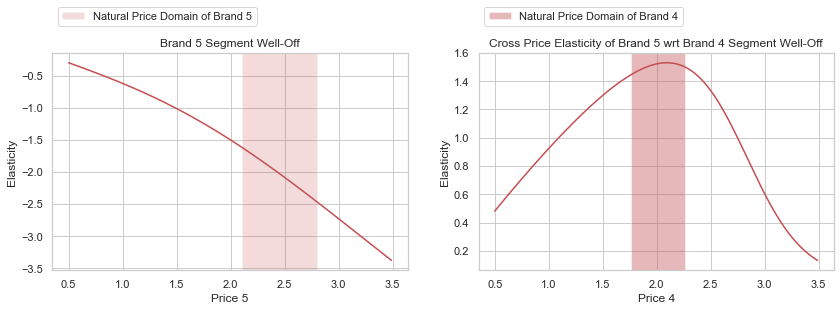

In [23]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_WO, color = 'r')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='r', alpha=0.2, label = "Natural Price Domain of Brand 5")

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_WO, color = 'r')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='r', alpha=0.4, label = "Natural Price Domain of Brand 4")

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

In [24]:
# The natural price range of Brand 4
brand_choice.Price_4.min(), brand_choice.Price_4.max()

(1.76, 2.26)

In [25]:
# The natural price range of Brand 5
brand_choice.Price_5.min(), brand_choice.Price_5.max()

(2.11, 2.8)

#### Well-Off
> Notice that while the X axes both show the same price range, the left plot refers to changes in the price of "Brand 5", the right plot refers to changes in the price of "Brand 4". Also, the red-coloured zone in both plots indicates the natural price range of Brand  5, 4, respectively, It is worth focusing on this point of the graph. 
>- **"Own Price Elasticity"** indicates that well-off customers is elastic to the own brand (Brand 5). This can be verified from the descriptive analysis table that indeed over 60 percent of the well-off segment purchased brand 4 at about 20 percent by brand 5.
>- **"Cross Price Elasticities"**: The values of elasticity are positive indicating that for the well off's brand 4 is substitute for brand 5. 

> For example, assume that Brand 5 costs 2,40 dollars. Then the own price elasticity is -1,97. Moreover, when Brand 4 cost 2,00, the cross price elasticity is about 1,53. <br>
>- If the competitor Brand 4 decrease its prices by 1%, then the cross price elasticity is 1,53, thus the purchase probability of our brand (Brand 5) will fall by 1,53%.
>-  To strike back we can also set lower our own price by 1%, we must look at the "own" price elasticity of our brand (the left plot), since it is minus to a 1 percent decrease in our price would be reflected in a 1,97% increase in purchase profitability. The net effect of the two price decreases is 1,97% - 1,53% = 0,44 %. Therefore, we have reacted to the competitors price range and have actually gained some market share.
>-  With the price elasticities, we can also react to the  competitor to keep the purchase probability constant. We establish that if brand 4 decreases their price by 1 %, the purchase probability for brand 5 would decrease by 1,53 %. Let's say, X is the decrease in price we require to reach a 1,53% increase in purchase probability. Then we can make an equation: X*2,00 = 1,53%, to match that by our own price decrease.  X is equal to 0,76%. If brand 4 decreases their price by 1 percent, we can decrease ours by 0,75% and
theoretically we will not lose a single customer from the well-off segment.


<a id='Segment0'></a>
### Standard (Segment 0) 

In [26]:
brand_choice_Strd= df_pa.query('Incidence ==1 & Segment == 0')

# Brand Choice Model estimation.
output_Strd = brand_choice_Strd['Brand']
brand_choice_Strd = pd.get_dummies(brand_choice_Strd, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
inputs_Strd = brand_choice_Strd[features]

model_brand_choice_Strd = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_Strd.fit(inputs_Strd, output_Strd)

# Coefficients table for Standard. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_Strd.coef_), columns = coefficients, index = prices)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.99,1.60,1.17,0.22,0.99
Price_2,0.65,-2.14,0.11,0.27,1.11
Price_3,1.29,0.08,1.11,-0.28,-2.19
Price_4,1.30,-0.31,1.53,-1.49,-1.03
Price_5,0.93,1.26,0.18,0.58,-2.94


### (Standard) Own-Brand Price Elasticity: Brand 5

In [27]:
# Calculate own-brand price elasticity for brand 5 and the Standard segment.
own_brand_5_Strd = pd.DataFrame({'Price1_Strd_OBPE':  brand_choice_Strd['Price_1'].mean(),
                                 'Price2_Strd_OBPE':  brand_choice_Strd['Price_2'].mean(), 
                                 'Price3_Strd_OBPE':  brand_choice_Strd['Price_3'].mean(),
                                 'Price4_Strd_OBPE':  brand_choice_Strd['Price_4'].mean(),
                                 'Price5_Strd_OBPE':  price_range} , index = np.arange(price_range.size))

own_brand_5_Strd.head()

,Price1_Strd_OBPE,Price2_Strd_OBPE,Price3_Strd_OBPE,Price4_Strd_OBPE,Price5_Strd_OBPE
0,1.38,1.74,2.01,2.16,0.50
1,1.38,1.74,2.01,2.16,0.51
2,1.38,1.74,2.01,2.16,0.52
3,1.38,1.74,2.01,2.16,0.53
4,1.38,1.74,2.01,2.16,0.54


In [28]:
pred_own_brand_5_Strd = model_brand_choice_Strd.predict_proba(own_brand_5_Strd)
pr_own_brand_5_Strd = pred_own_brand_5_Strd[: ][: , 4]

# Compute price elasticities and update master dataframe.
own_price_elasticity_brand_5_Strd =  beta5 * price_range * (1 - pr_own_brand_5_Strd) 
price_elasticities.loc['Brand5_own_PE_Standard'] = own_price_elasticity_brand_5_Strd

### (Standard) Cross-Brand Price Elasticity: Brand 5 vs. 4

In [29]:
# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
brand5_cross_brand4_Strd = pd.DataFrame({'B5CB4_Price_1':  brand_choice_Strd['Price_1'].mean(),
                                       'B5CB4_Price_2':  brand_choice_Strd['Price_2'].mean(), 
                                       'B5CB4_Price_3':  brand_choice_Strd['Price_3'].mean(),
                                       'B5CB4_Price_4':  price_range,
                                       'B5CB4_Price_5':  brand_choice_Strd['Price_5'].mean()},
                                        index = np.arange(price_range.size))

pred_brand5_cross_brand4_Strd = model_brand_choice_Strd.predict_proba(brand5_cross_brand4_Strd)
pr_cross_brand_5_Strd = pred_brand5_cross_brand4_Strd[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_Strd = -beta5 * price_range * pr_cross_brand_5_Strd
price_elasticities.loc['Brand5_Cross_Brand_4_Standard'] = brand5_cross_brand4_price_elasticity_Strd

### (Standard) Visualizations

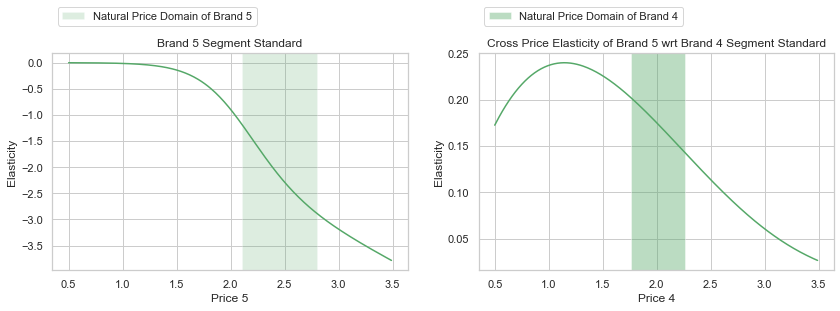

In [30]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_Strd, color = 'g')
axs[0].set_title('Brand 5 Segment Standard')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='g', alpha=0.2, label = "Natural Price Domain of Brand 5")


axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, color = 'g')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Standard')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='g', alpha=0.4, label = "Natural Price Domain of Brand 4")

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

#### Standard Segment

Like before, note that the X axes refer to the price of brand 5 and price of brand 4 respectively. The y-axis reflects the own price elasticity (on the left plot) or the cross price elasticity (on the right plot). Standard customer is more elastic when compared to the average customers. The difference becomes even more pronounced when we compared the standards to other segments.

The greed-coloured area indicate the natural price domain of Brand 5 (left plot) and Brand 4 (right plot) The elasticity of the standard segment is between -1,42 and -1,27. Therefore its purchase probability for the own brand is elastic for the entire observed price range of the brand.

If the company is planning to win some of the standard segment market, the appropriate marketing strategy would be to lower prices in this price range to increase the purchase probability for this segment. However, considering that this segment isn't quite homogenous and a marketing strategy based on only this segment might be risky.


<a id='Segment1'></a>
### Career-Focused (Segment 1) 

In [31]:
brand_choice_Cf= df_pa.query('Incidence ==1 & Segment == 1')

# Brand Choice Model estimation.
output_Cf = brand_choice_Cf['Brand']
brand_choice_Cf = pd.get_dummies(brand_choice_Cf, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
inputs_Cf = brand_choice_Cf[features]

model_brand_choice_Cf = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_Cf.fit(inputs_Cf, output_Cf)

# Coefficients table for Standard. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_Cf.coef_), columns = coefficients, index = prices)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.38,1.13,1.39,-0.02,-0.11
Price_2,0.74,-1.67,0.06,0.40,0.47
Price_3,1.15,0.34,0.45,-1.74,-0.20
Price_4,0.04,0.59,0.42,-1.07,0.03
Price_5,-0.02,-0.13,0.32,0.40,-0.58


### (Career-Focused) Own-Brand Price Elasticity: Brand 5

In [32]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
own_brand_5_Cf = pd.DataFrame({'Price1_Cf_OBPE':  brand_choice_Cf['Price_1'].mean(),
                               'Price2_Cf_OBPE':  brand_choice_Cf['Price_2'].mean(), 
                               'Price3_Cf_OBPE':  brand_choice_Cf['Price_3'].mean(),
                               'Price4_Cf_OBPE':  brand_choice_Cf['Price_4'].mean(),
                               'Price5_Cf_OBPE':  price_range} , index = np.arange(price_range.size))

own_brand_5_Cf.head()

,Price1_Cf_OBPE,Price2_Cf_OBPE,Price3_Cf_OBPE,Price4_Cf_OBPE,Price5_Cf_OBPE
0,1.39,1.77,2.01,2.16,0.50
1,1.39,1.77,2.01,2.16,0.51
2,1.39,1.77,2.01,2.16,0.52
3,1.39,1.77,2.01,2.16,0.53
4,1.39,1.77,2.01,2.16,0.54


In [33]:
pred_own_brand_5_Cf = model_brand_choice_Cf.predict_proba(own_brand_5_Cf)
pr_own_brand_5_Cf = pred_own_brand_5_Cf[: ][: , 4]

# Compute price elasticities and update master dataframe.
own_price_elasticity_brand_5_Cf =  beta5 * price_range * (1 - pr_own_brand_5_Cf) 
price_elasticities.loc['Brand5_own_PE_Career_Focused'] = own_price_elasticity_brand_5_Cf

### (Career-Focused) Cross-Brand Price Elasticity: Brand 5 vs. 4

In [34]:
# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
brand5_cross_brand4_Cf = pd.DataFrame({'B5CB4_Price_1':  brand_choice_Cf['Price_1'].mean(),
                                       'B5CB4_Price_2':  brand_choice_Cf['Price_2'].mean(), 
                                       'B5CB4_Price_3':  brand_choice_Cf['Price_3'].mean(),
                                       'B5CB4_Price_4':  price_range,
                                       'B5CB4_Price_5':  brand_choice_Cf['Price_5'].mean()},
                                        index = np.arange(price_range.size))

pred_brand5_cross_brand4_Cf = model_brand_choice_Cf.predict_proba(brand5_cross_brand4_Cf)
pr_cross_brand_5_Cf = pred_brand5_cross_brand4_Cf[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_Cf = -beta5 * price_range * pr_cross_brand_5_Cf
price_elasticities.loc['Brand5_Cross_Brand_4_Career_Focused'] = brand5_cross_brand4_price_elasticity_Cf

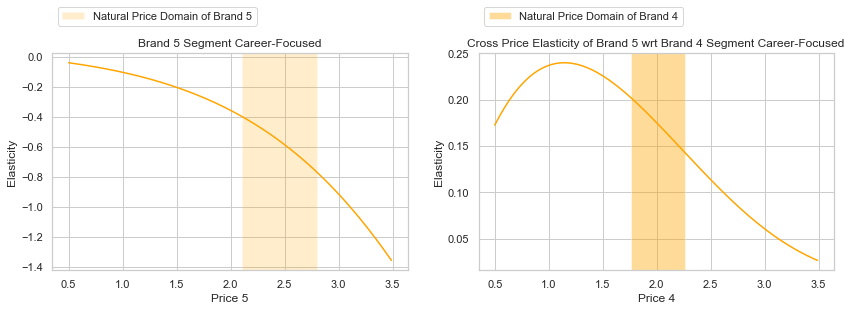

In [35]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_Cf, color = 'orange')
axs[0].set_title('Brand 5 Segment Career-Focused')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='orange', alpha=0.2, label = "Natural Price Domain of Brand 5")


axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Career-Focused')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='orange', alpha=0.4, label = "Natural Price Domain of Brand 4")


for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

#### Career Focused 

Career Focused customers are the least elastic among the rest. They seem to be inelastic throughout the whole price range.
In other words, it means that this segment is not really affected by the increase in the price of the own brand.

In addition, the values of cross price elasticity in this segment is also exceptionally low. This type of customers is unlikely to switch to the competitor brand. They are loyal to the brand and the company could increase prices of its own brand without fear of losing too much market share.


<a id='Segment2'></a>
### Fewer-Opportunities (Segment 2) 

In [36]:
brand_choice_FO= df_pa.query('Incidence ==1 & Segment == 2')

# Brand Choice Model estimation.
output_FO = brand_choice_FO['Brand']
brand_choice_FO = pd.get_dummies(brand_choice_FO, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
inputs_FO = brand_choice_FO[features]

model_brand_choice_FO = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_FO.fit(inputs_FO, output_FO)

# Coefficients table for Standard. 
bc_coef_FO = pd.DataFrame(np.transpose(model_brand_choice_FO.coef_), columns = coefficients, index = prices)
bc_coef_FO

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.01,1.09,1.19,0.27,0.47
Price_2,0.75,-2.06,0.46,0.37,0.48
Price_3,1.20,-0.50,0.36,-0.06,-1.00
Price_4,0.44,-0.28,0.99,-1.25,0.11
Price_5,-0.07,1.40,0.68,-0.86,-1.15


### (Fewer-Opportunities) Own-Brand Price Elasticity: Brand 5

In [37]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
own_brand_5_FO = pd.DataFrame({'Price1_FO_OBPE':  brand_choice_FO['Price_1'].mean(),
                               'Price2_FO_OBPE':  brand_choice_FO['Price_2'].mean(), 
                               'Price3_FO_OBPE':  brand_choice_FO['Price_3'].mean(),
                               'Price4_FO_OBPE':  brand_choice_FO['Price_4'].mean(),
                               'Price5_FO_OBPE':  price_range} , index = np.arange(price_range.size))

own_brand_5_FO.head()

,Price1_FO_OBPE,Price2_FO_OBPE,Price3_FO_OBPE,Price4_FO_OBPE,Price5_FO_OBPE
0,1.38,1.77,2.01,2.16,0.50
1,1.38,1.77,2.01,2.16,0.51
2,1.38,1.77,2.01,2.16,0.52
3,1.38,1.77,2.01,2.16,0.53
4,1.38,1.77,2.01,2.16,0.54


In [38]:
pred_own_brand_5_FO = model_brand_choice_FO.predict_proba(own_brand_5_FO)
pr_own_brand_5_FO = pred_own_brand_5_FO[: ][: , 4]

# Compute price elasticities and update master dataframe.
own_price_elasticity_brand_5_FO =  beta5 * price_range * (1 - pr_own_brand_5_FO) 
price_elasticities.loc['Brand5_own_PE_Fewer_Opportunities'] = own_price_elasticity_brand_5_FO

### (Fewer-Opportunities) Cross-Brand Price Elasticity: Brand 5 vs. 4

In [39]:
# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer_Opportunities. 
brand5_cross_brand4_FO = pd.DataFrame({'B5CB4_Price_1':  brand_choice_FO['Price_1'].mean(),
                                       'B5CB4_Price_2':  brand_choice_FO['Price_2'].mean(), 
                                       'B5CB4_Price_3':  brand_choice_FO['Price_3'].mean(),
                                       'B5CB4_Price_4':  price_range,
                                       'B5CB4_Price_5':  brand_choice_FO['Price_5'].mean()},
                                        index = np.arange(price_range.size))

pred_brand5_cross_brand4_FO = model_brand_choice_FO.predict_proba(brand5_cross_brand4_FO)
pr_cross_brand_5_FO = pred_brand5_cross_brand4_FO[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_FO = -beta5 * price_range * pr_cross_brand_5_FO
price_elasticities.loc['Brand5_Cross_Brand_4_Fewer_Opportunities'] = brand5_cross_brand4_price_elasticity_FO
pd.options.display.max_columns = None
price_elasticities.to_csv('price_elasticities_2.csv')
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price_Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean_PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.96,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.42,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.54,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.59,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.81,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

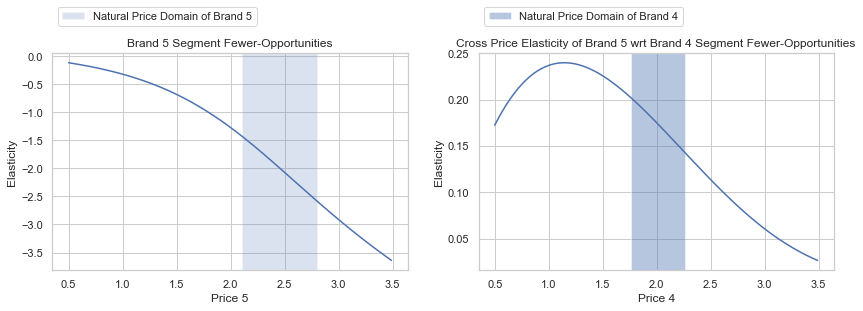

In [40]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_FO, color = 'b')
axs[0].set_title('Brand 5 Segment Fewer-Opportunities')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='b', alpha=0.2, label = "Natural Price Domain of Brand 5")


axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, color = 'b')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Fewer-Opportunities')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='b', alpha=0.4, label = "Natural Price Domain of Brand 4")


for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

#### Fewer Opportunities segment

The own price elasticity (left plot) has a more pronounced shape. This segment seems to be inelastic at lower price points and then customers become rapidly elastic at higher prices. Considering the natural price range (blue-coloured area) of the brand_5, this segment customers are rather elastic. As for Career-Focused segment, Fewer Opportunities seem loyal to brand 5, comparing to brand 4, according to the Cross price elasticity. 

As shown in descriptive analysis (Part 2-1), Fewer-Opportunities segment almost never buys brand 5 nor brand 4. The correlations are 0.066 and 0.098, respectively. This means we don't have enough observations to obtain an accurate model and that could be the reason why both curves look so out of character. Therefore, to target this segment in particular brand 5, more purchase data especially from this segment of people are necessary. However, if a product may be too pricey for a segment, we may never obtain more data about their behaviour. These people are simply not the target group for Brand 5.


### Visualizations of All Segments

In [41]:
minor_ticks = np.arange(-4, 2, 1)
minor_ticks

array([-4, -3, -2, -1,  0,  1])

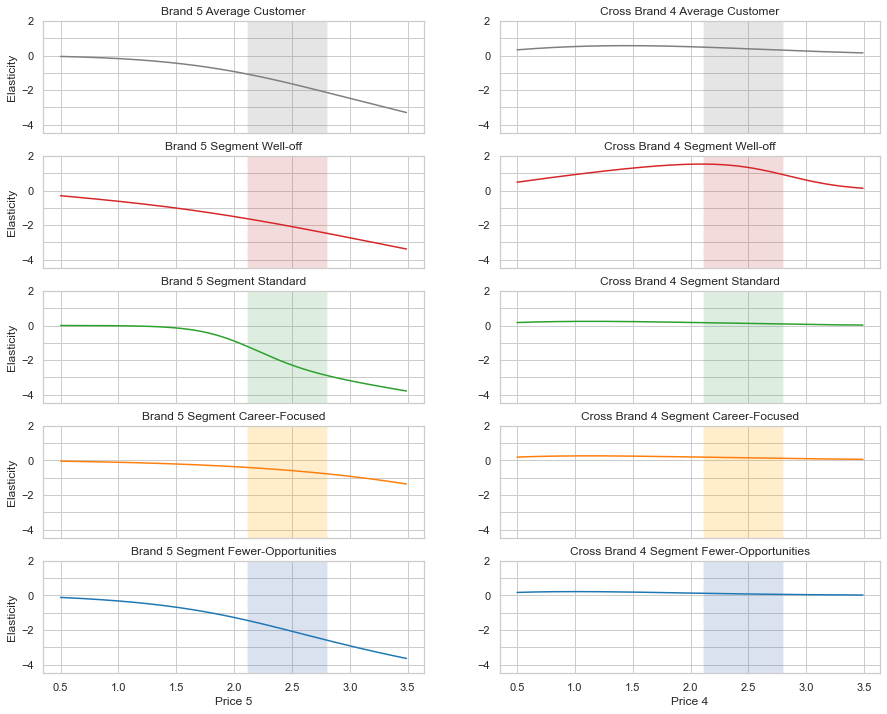

In [42]:
#plot the own and cross brand price elasticities for the average customer and each of the four segments.
minor_ticks = np.arange(-4, 2, 1)
custom_ylim = (-4.5, 2.0)
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (15, 12), sharex = True )

# Average
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[0].set_ylim([-4.5, 2.0])
ax1[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='grey', alpha=0.2)
ax1[0].set_yticks(minor_ticks, minor=True)
ax1[0].grid(  which = 'minor', axis = 'y' )

ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')
ax1[1].set_ylim([-4.5, 2.0])
ax1[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='grey', alpha=0.2)
ax1[1].set_yticks(minor_ticks, minor=True)
ax1[1].grid(  which = 'minor', axis = 'y' )

# Well-off
ax2[0].plot(price_range, own_price_elasticity_brand_5_WO, 'tab:red')
ax2[0].set_title('Brand 5 Segment Well-off')
ax2[0].set_ylabel('Elasticity')
ax2[0].set_ylim([-4.5, 2.0])
ax2[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='r', alpha=0.2)
ax2[0].set_yticks(minor_ticks, minor=True)
ax2[0].grid(  which = 'minor', axis = 'y' )

ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_WO, 'tab:red')
ax2[1].set_title('Cross Brand 4 Segment Well-off')
ax2[1].set_ylim([-4.5, 2.0])
ax2[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='r', alpha=0.2)
ax2[1].set_yticks(minor_ticks, minor=True)
ax2[1].grid(  which = 'minor', axis = 'y' )


# Standard Segment
ax3[0].plot(price_range, own_price_elasticity_brand_5_Strd, 'tab:green')
ax3[0].set_title('Brand 5 Segment Standard')
ax3[0].set_ylabel('Elasticity')
ax3[0].set_ylim([-4.5, 2.0])
ax3[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='g', alpha=0.2)
ax3[0].set_yticks(minor_ticks, minor=True)
ax3[0].grid(  which = 'minor', axis = 'y' )
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Standard')
ax3[1].set_ylim([-4.5, 2.0])
ax3[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='g', alpha=0.2)
ax3[1].set_yticks(minor_ticks, minor=True)
ax3[1].grid(  which = 'minor', axis = 'y' )

# Career-Focused
ax4[0].plot(price_range, own_price_elasticity_brand_5_Cf, 'tab:orange')
ax4[0].set_title('Brand 5 Segment Career-Focused')
ax4[0].set_ylabel('Elasticity')
ax4[0].set_ylim([-4.5, 2.0])
ax4[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='orange', alpha=0.2)
ax4[0].set_yticks(minor_ticks, minor=True)
ax4[0].grid(  which = 'minor', axis = 'y' )
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_Cf, 'tab:orange')
ax4[1].set_title('Cross Brand 4 Segment Career-Focused')
ax4[1].set_ylim([-4.5, 2.0])
ax4[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='orange', alpha=0.2)
ax4[1].set_yticks(minor_ticks, minor=True)
ax4[1].grid(  which = 'minor', axis = 'y' )

# Fewer-Opportunities
ax5[0].plot(price_range, own_price_elasticity_brand_5_FO, 'tab:blue')
ax5[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[0].set_ylim([-4.5, 2.0])
ax5[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='b', alpha=0.2)
ax5[0].set_yticks(minor_ticks, minor=True)
ax5[0].grid(  which = 'minor', axis = 'y' )

ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_FO, 'tab:blue')
ax5[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')
ax5[1].set_xlabel('Price 4')
ax5[1].set_ylim([-4.5, 2.0])
ax5[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='b', alpha=0.2)
ax5[1].set_yticks(minor_ticks, minor=True)
ax5[1].grid(  which = 'minor', axis = 'y' )

To get more insights, all own price elasticities and cross price elasticities are presented side by side. The two plots in the first row represents the average customer, while the following lines represent each segment.  Also, the plots are presented with shared y and x axis. It is better to compare the plots with the findings of descriptive analysis (Part 2-1). 

It seems that Career-Focused and Well-Off segments require the most attention as both groups are actually the people that purchase brand 5. Well-off segment is much more elastic than the Career-Focused. In other words, increasing the prices would barely affect the Career-Focused segment but would seriously damage Well-Off segment sales. 

If brand 4 were to decrease their price, then it would affect the Well-Off segment, but not the career focused one. A tiny decrease in our pricing would compensate such a competitor move. If prices of chocolates were to drop, we would have space to decrease our price offering while gaining solid market share from the Well-Off segment and practically retaining the Career-Focused customer base.
